In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv('airbnb_sydney.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              25480 non-null  int64  
 1   name                            25480 non-null  object 
 2   host_id                         25480 non-null  int64  
 3   host_name                       25478 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   25480 non-null  object 
 6   latitude                        25480 non-null  float64
 7   longitude                       25480 non-null  float64
 8   room_type                       25480 non-null  object 
 9   price                           24382 non-null  float64
 10  minimum_nights                  25480 non-null  int64  
 11  number_of_reviews               25480 non-null  int64  
 12  last_review                     

In [10]:
df.isna().sum()

id                                    0
name                                  0
host_id                               0
host_name                             2
neighbourhood_group               25480
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                              1098
minimum_nights                        0
number_of_reviews                     0
last_review                        7205
reviews_per_month                  7205
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           10457
dtype: int64

In [11]:
# dropping unimportant features
df = df.drop(['id', 'host_name', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'last_review', 'reviews_per_month', 'license'], axis=1)

In [12]:
# extracting features from name column
import re
def extract_values(text, pattern):
    match = pattern.search(text)

    return  match.group(1) if match else None

bedroom_pattern = re.compile("(\d+)\s*bedroom(s?)(\s+)")
bed_pattern = re.compile("(\d+)\s*bed(s?)(\s+)")
bath_pattern = re.compile("(\d+)(\.\d+)?\s*(shared | private)?\s*bath(s?)")
star_pattern = re.compile("★\d+(\.\d+)?")

df['num_bedrooms'] = df['name'].apply(func=lambda x: extract_values(x, bedroom_pattern)).astype('float')
df['num_bathrooms'] = df['name'].apply(func=lambda x: extract_values(x, bath_pattern)).astype('float')
df['num_beds'] = df['name'].apply(func=lambda x: extract_values(x, bed_pattern)).astype('float')
df['stars'] = df['name'].apply(func=lambda x: extract_values(x, star_pattern)).astype('float')

# after extracting features we remove name column
df = df.drop(['name'], axis=1)

In [13]:
# creating binary columns from the column room_type
df['private_room'] = df['room_type'].apply(func=lambda row: 1 if row == 'Private room' else 0)
df['shared_room'] = df['room_type'].apply(func=lambda row: 1 if row == 'Shared room' else 0)
df['hotel_room'] = df['room_type'].apply(func=lambda row: 1 if row == 'Hotel room' else 0)
df['entire_room'] = df['room_type'].apply(func=lambda row: 1 if row == 'Entire home/apt' else 0)

# deleting room_type column
df = df.drop(['room_type'], axis=1)

In [14]:
# removing rows where price is missing
df = df.dropna(subset=['price'], axis=0)

In [15]:
# Changing missing values to mean value
df['num_bedrooms'] = df['num_bedrooms'].fillna(df['num_bedrooms'].mean())
df['num_bathrooms'] = df['num_bathrooms'].fillna(df['num_bathrooms'].mean())
df['num_beds'] = df['num_beds'].fillna(df['num_beds'].mean())
df['stars'] = df['stars'].fillna(df['stars'].mean())

<Axes: >

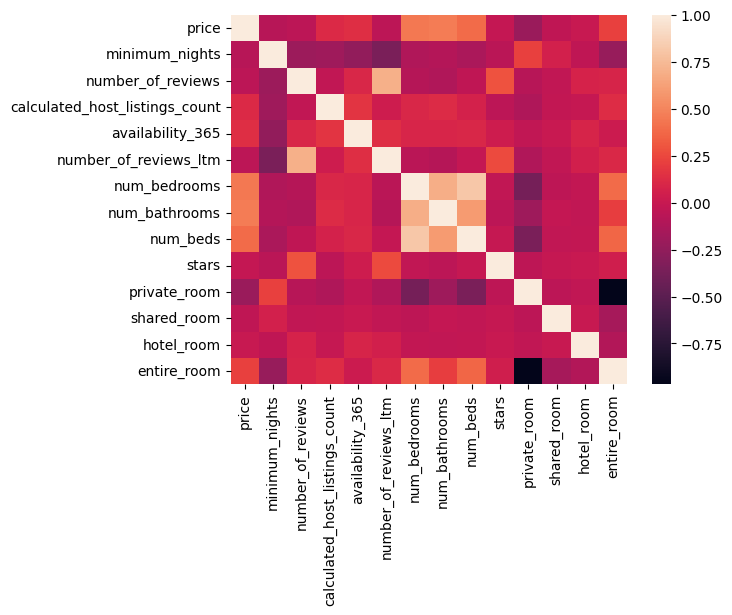

In [16]:
corr = df.corr()
sns.heatmap(corr)

**Training a model**

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns_to_normalize = df.columns[df.columns != 'price']
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'price'],
                                                    df['price'])

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
mse = mean_squared_error(y_test, predictions)
print(f"Score: {score}, MSE: {mse}")

Score: 0.29356466750955035, MSE: 221454.83217478674


In [21]:
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
mse = mean_squared_error(y_test, predictions)
print(f"Score: {score}, MSE: {mse}")

Score: 0.29335975470181763, MSE: 221519.06867225483


In [22]:
model = Lasso()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
mse = mean_squared_error(y_test, predictions)
print(f"Score: {score}, MSE: {mse}")

Score: 0.29270839028825135, MSE: 221723.2597570671


**KNN Regressor**

In [23]:
from sklearn.neighbors import KNeighborsRegressor

In [24]:
model = KNeighborsRegressor(n_neighbors = 47)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
# score = 1 - (np.sum((predictions - y_test) ** 2) / np.sum((y_test - y_test.mean())** 2))
score

0.369421763356243

In [25]:
scores = []
neighbors = np.arange(1, 50)
mse1 = []
for k in range(1, 50):
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, model.predict(X_test))
    scores.append(score)
    mse1.append(mse)

    print(f"n_neighbors: {k}, score: {score}, mse: {mse}")

n_neighbors: 1, score: 0.027672175255408216, mse: 304807.3692585302
n_neighbors: 2, score: 0.20473375246616077, mse: 249301.734046916
n_neighbors: 3, score: 0.2641750989870669, mse: 230667.93585958006
n_neighbors: 4, score: 0.30452788637933026, mse: 218018.05929092848
n_neighbors: 5, score: 0.2342079926986369, mse: 240062.0872965879
n_neighbors: 6, score: 0.2636343947564693, mse: 230837.43695775003
n_neighbors: 7, score: 0.2865656028121095, mse: 223648.91368043283
n_neighbors: 8, score: 0.317988855765727, mse: 213798.28632761238
n_neighbors: 9, score: 0.3354056424259714, mse: 208338.4354545381
n_neighbors: 10, score: 0.33486582687510236, mse: 208507.65796751974
n_neighbors: 11, score: 0.33549221310461497, mse: 208311.29709632113
n_neighbors: 12, score: 0.3426974907688469, mse: 206052.5715166138
n_neighbors: 13, score: 0.3480276549607364, mse: 204381.66044763083
n_neighbors: 14, score: 0.3541984436657022, mse: 202447.2286402258
n_neighbors: 15, score: 0.3545973929232151, mse: 202322.165

In [26]:
def vizualize_metrics(n_neighbors, scores, mse):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('R2 score')
    plt.plot(n_neighbors, scores, color='blue')
    plt.xlabel('n_neighbors')
    plt.ylabel('score')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('MSE')
    plt.plot(n_neighbors, mse1, color='red')
    plt.xlabel('n_neighbors')
    plt.ylabel('mse')
    plt.grid()

    plt.tight_layout()
    plt.show()

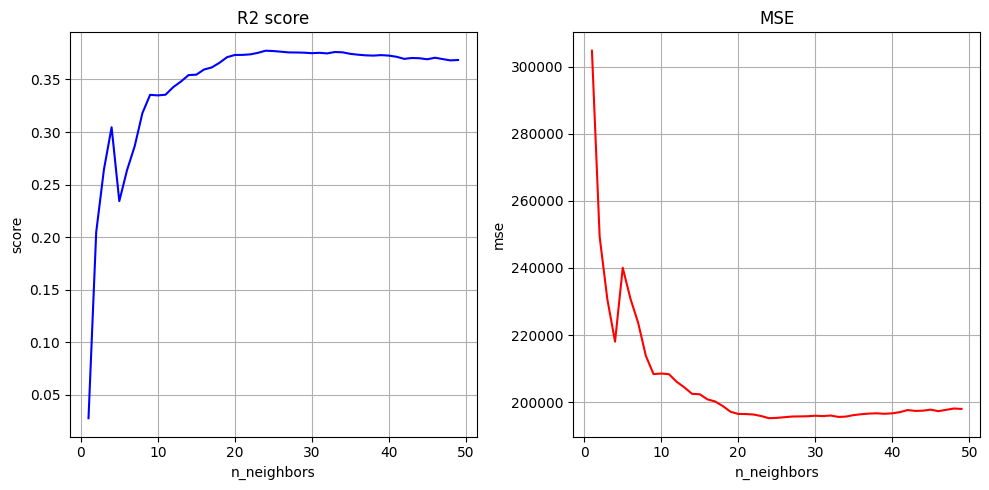

In [27]:
vizualize_metrics(neighbors, scores, mse1)

In [28]:
# best number of neighbors
np.argmax(scores), np.argmin(mse1)

(23, 23)

KNN Classifier

In [29]:
# create a list of conditions
conditions = [
    (df['price'] < 100),
    (df['price'] >= 100) & (df['price'] < 250),
     (df['price'] >= 250) & (df['price'] < 600),
    (df['price'] >= 600) ]

# create a list of the values we want to assign for each condition
categories = ['economic', 'low-mid', 'high-mid','high']

# create a new column and use np.select to assign values to it using our lists as arguments
df['price_range'] = np.select(conditions, categories)

In [30]:
labelencoder = LabelEncoder()
df['price_range_cat'] = labelencoder.fit_transform(df['price_range'])

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
# new df without price_range and price columns for knn classifier
df1 = df[['minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'num_bedrooms', 'num_bathrooms', 'num_beds',
       'stars', 'private_room', 'shared_room', 'hotel_room', 'entire_room','price_range_cat']]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df1.loc[:, df1.columns != 'price_range_cat'],
                                                    df1['price_range_cat'])

In [34]:
mse1 = []
scores = []
neighbors = np.arange(1, 50)
for k in range(1, 50):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    score = model.score(X_test, y_test)
    scores.append(score)
    mse1.append(mse)
    print(f"n_neighbors: {k}, score: {score}, mse: {mse}")

n_neighbors: 1, score: 0.5457677165354331, mse: 1.5761154855643045
n_neighbors: 2, score: 0.5333005249343832, mse: 1.643208661417323
n_neighbors: 3, score: 0.5767716535433071, mse: 1.587270341207349
n_neighbors: 4, score: 0.59251968503937, mse: 1.393044619422572
n_neighbors: 5, score: 0.6012139107611548, mse: 1.3558070866141732
n_neighbors: 6, score: 0.6023622047244095, mse: 1.3654855643044619
n_neighbors: 7, score: 0.6076115485564304, mse: 1.3448162729658792
n_neighbors: 8, score: 0.6095800524934383, mse: 1.33251312335958
n_neighbors: 9, score: 0.61499343832021, mse: 1.3400590551181102
n_neighbors: 10, score: 0.6122047244094488, mse: 1.3318569553805775
n_neighbors: 11, score: 0.6195866141732284, mse: 1.3251312335958005
n_neighbors: 12, score: 0.6164698162729659, mse: 1.3254593175853018
n_neighbors: 13, score: 0.6207349081364829, mse: 1.3011811023622046
n_neighbors: 14, score: 0.6161417322834646, mse: 1.3138123359580052
n_neighbors: 15, score: 0.6276246719160105, mse: 1.284940944881889

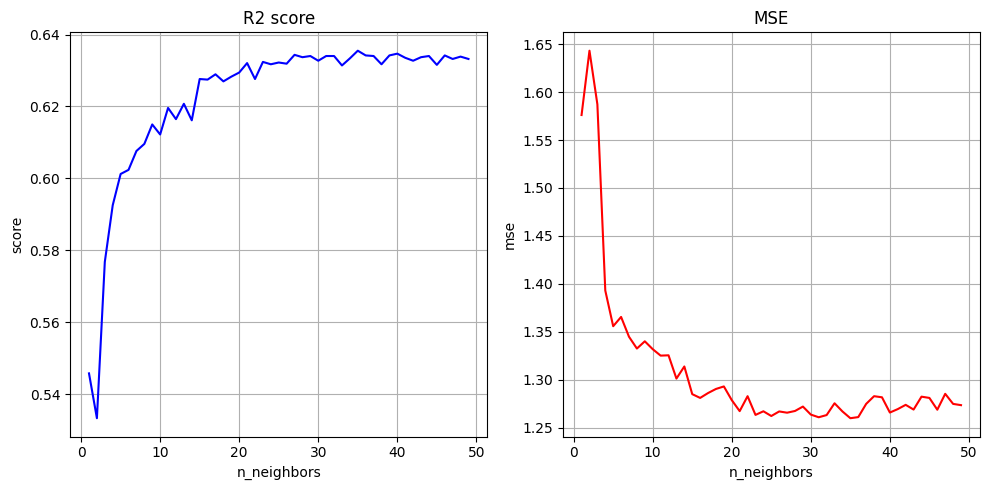

In [35]:
vizualize_metrics(neighbors, scores, mse1)

In [36]:
# best number of neighbors
np.argmax(scores), np.argmin(mse1)

(34, 34)

In [37]:
preds = pd.DataFrame({'actual': y_test.values, 'predicted': predictions})
preds

,actual,predicted
0,3,3
1,0,0
2,1,2
3,2,2
4,0,0
...,...,...
6091,2,3
6092,3,0
6093,3,2
6094,3,3


Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

In [39]:
tree = DecisionTreeClassifier(criterion='entropy', min_samples_split=2)
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)
accuracy = tree.score(X_test, y_test)
mse = mean_squared_error(y_test, predictions)

print(f"Accuracy: {accuracy}, MSE: {mse}")

Accuracy: 0.5800524934383202, MSE: 1.4860564304461943


In [40]:
for i in range(2, 100):
    tree = DecisionTreeClassifier(criterion='gini', min_samples_split=60, max_depth=i)
    tree.fit(X_train, y_train)
    predictions = tree.predict(X_test)
    accuracy = tree.score(X_test, y_test)
    mse = mean_squared_error(y_test, predictions)

    print(f"min_samples_split: {i}, Accuracy: {accuracy}, MSE: {mse}")

min_samples_split: 2, Accuracy: 0.5731627296587927, MSE: 1.5254265091863517
min_samples_split: 3, Accuracy: 0.6084317585301837, MSE: 1.2222769028871392
min_samples_split: 4, Accuracy: 0.6400918635170604, MSE: 1.2508202099737533


min_samples_split: 5, Accuracy: 0.6443569553805775, MSE: 1.238517060367454
min_samples_split: 6, Accuracy: 0.6474737532808399, MSE: 1.2344160104986877
min_samples_split: 7, Accuracy: 0.6474737532808399, MSE: 1.2150590551181102
min_samples_split: 8, Accuracy: 0.6491141732283464, MSE: 1.217027559055118
min_samples_split: 9, Accuracy: 0.6469816272965879, MSE: 1.24753937007874
min_samples_split: 10, Accuracy: 0.6504265091863517, MSE: 1.2350721784776904
min_samples_split: 11, Accuracy: 0.6481299212598425, MSE: 1.2358923884514437
min_samples_split: 12, Accuracy: 0.6520669291338582, MSE: 1.2245734908136483
min_samples_split: 13, Accuracy: 0.6525590551181102, MSE: 1.226049868766404
min_samples_split: 14, Accuracy: 0.6487860892388452, MSE: 1.2308070866141732
min_samples_split: 15, Accuracy: 0.6505905511811023, MSE: 1.229494750656168
min_samples_split: 16, Accuracy: 0.6481299212598425, MSE: 1.2378608923884515
min_samples_split: 17, Accuracy: 0.6478018372703412, MSE: 1.2376968503937007
min_sample

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [42]:
model = RandomForestClassifier()
random_forest = RandomForestClassifier(criterion='gini', min_samples_split=30)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
accuracy = random_forest.score(X_test, y_test)
mse = mean_squared_error(y_test, predictions)

print(f"Accuracy: {accuracy}, MSE: {mse}")

Accuracy: 0.6650262467191601, MSE: 1.1630577427821522


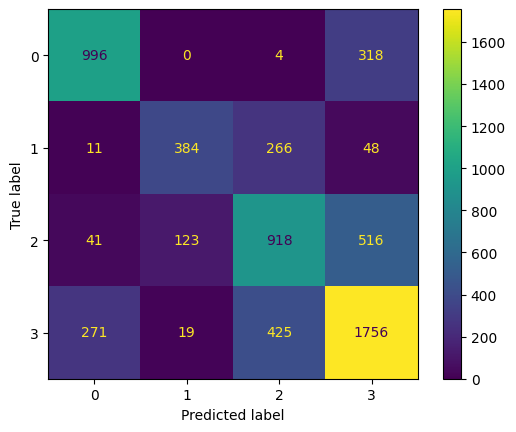

In [43]:
cm = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()